In [3]:
import sys
sys.path.append('/usr/local/ViennaRNA/python3.6/site-packages/') 

from models.RNA_landscapes import *
from utils.landscape_utils import *
from utils.sequence_utils import *

from ian_rna_utils import *
import RNA
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from matplotlib import rc
rc("font", family = "serif",size=20)
rc("figure",figsize=(9,6))
rc("figure",facecolor="white")
%config InlineBackend.figure_format = 'retina'
RNAA="CUGA"

def rmse(pred,target):
    return np.sqrt(((pred - target) ** 2).mean())

In [4]:
RNA.__file__

'/usr/local/ViennaRNA/lib/python3.6/site-packages/RNA/__init__.py'

In [5]:
bkd_inv = np.linalg.inv(gen_V(10)@gen_H(10))
ref_inv = np.linalg.inv(gen_G(10))



In [6]:
sequence_length = 20
n_mutations = 10
base_seq=generate_random_sequences(sequence_length,1,alphabet=RNAA)[0]
mut_seq, mut_list = gen_n_mutations(base_seq,n_mutations)
mut_list 

y =calc_phenotype(base_seq,mut_list)
def f(epi,inv_matrix,n_terms,y,error_metric = 'rmse'):
    sig_idx = np.flip(np.argsort(np.abs(epi)),axis=0)[:n_terms]
    pred = inv_matrix[:,sig_idx] @ epi[sig_idx]
    if error_metric == 'rmse':
        return rmse(pred,y)
    elif error_metric =='gop':
        return GOP(pred,y)

Ns = np.arange(1024)
errs_bkd = np.zeros(Ns.shape)
errs_ref = np.zeros(Ns.shape)

bkd_epi = calc_bkd_epi(y)
ref_epi = calc_ref_epi(y)

err_metric = 'gop'
for n in tqdm(range(Ns.shape[0])):
    
    errs_bkd[n] = f(bkd_epi,bkd_inv,Ns[n],y,err_metric)
    errs_ref[n] = f(ref_epi,ref_inv,Ns[n],y,err_metric)
    
    

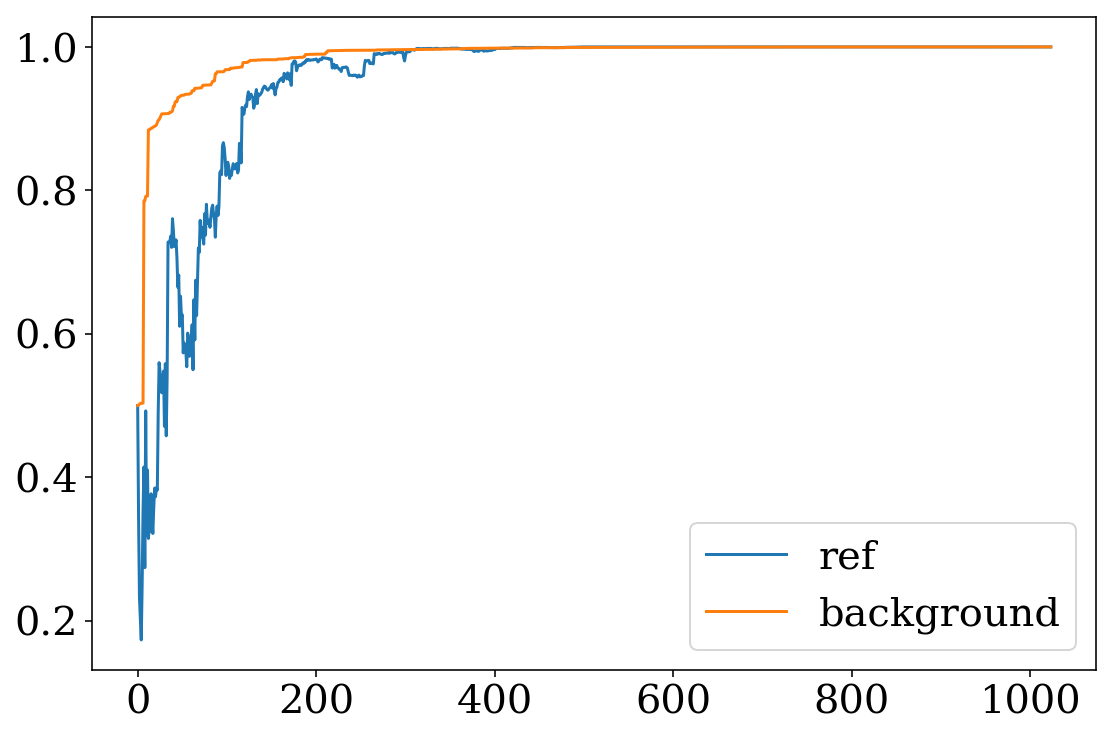

In [9]:
plt.plot(Ns,errs_ref,label='ref')
plt.plot(Ns,errs_bkd,label='background')
plt.legend()
# plt.yscale('log')
# plt.xscale('log')
plt.show()

In [17]:
sequence_length = 20
n_mutations = 10
base_seq=generate_random_sequences(sequence_length,1,alphabet=RNAA)[0]
mut_seq, mut_list = gen_n_mutations(base_seq,n_mutations)
mut_list 
orders_10 = get_order_list(10)

y = calc_phenotype(base_seq,mut_list)
def f_order(epi,inv_matrix,order,y,error_metric = 'rmse',order_list = None,):
    if order_list is None:
        order_list = get_order_list(np.int(np.log2(epi.shape[0])))
    idx = order_list <= order

    pred = inv_matrix[:,idx] @ epi[idx]
    if error_metric == 'rmse':
        return rmse(pred,y)
    elif error_metric =='gop':
        return GOP(pred,y)

Ns = np.arange(1024)
errs_bkd = np.zeros(n_mutations)
errs_ref = np.zeros(n_mutations)

bkd_epi = calc_bkd_epi(y)
ref_epi = calc_ref_epi(y)

err_metric = 'gop'
for n in tqdm(range(10)):
    
    errs_bkd[n] = f_order(bkd_epi,bkd_inv,Ns[n],y,err_metric)
    errs_ref[n] = f_order(ref_epi,ref_inv,Ns[n],y,err_metric)
    
    

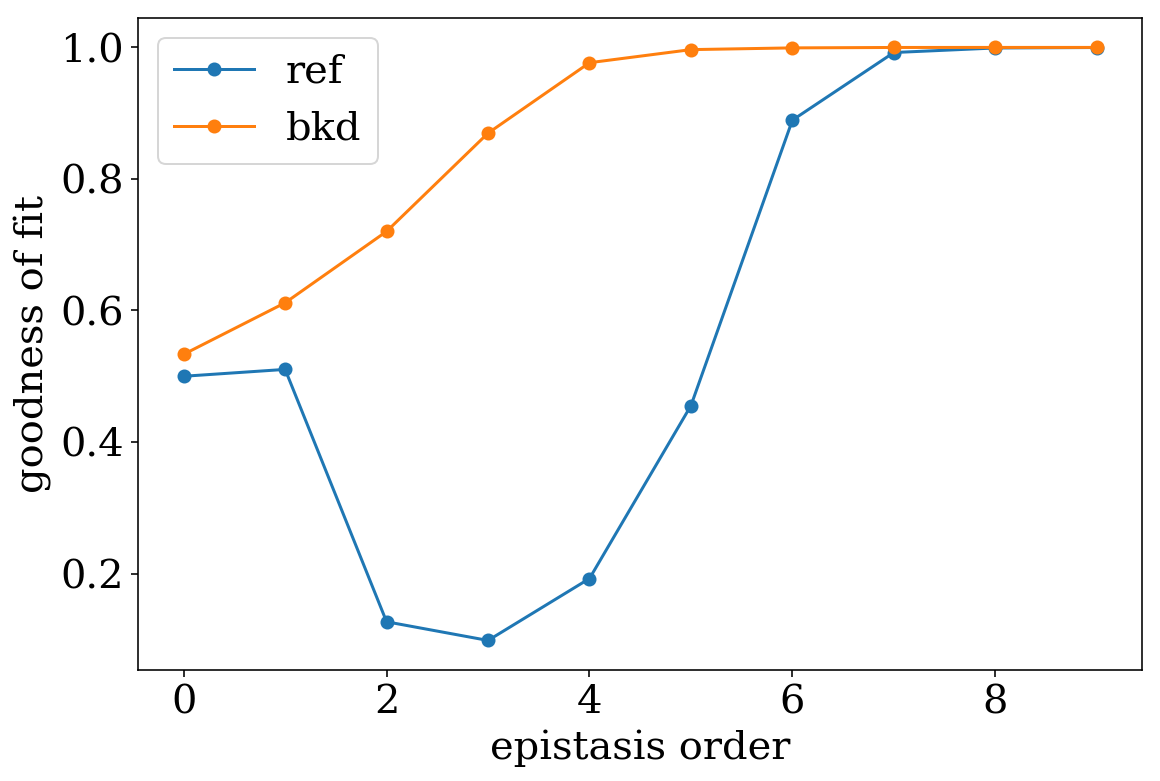

In [19]:
plt.plot(errs_ref,'-o',label='ref')
plt.plot(errs_bkd,'-o',label='bkd')
plt.legend()
plt.xlabel('epistasis order')
plt.ylabel('goodness of fit')
plt.show()

In [25]:
def dododo():
    base_seq=generate_random_sequences(sequence_length,1,alphabet=RNAA)[0]
    mut_seq, mut_list = gen_n_mutations(base_seq,n_mutations)
    orders_10 = get_order_list(10)

    y =calc_phenotype(base_seq,mut_list)
    def f_order(epi,inv_matrix,order,y,error_metric = 'rmse'):
        idx = orders_10 <= order
        pred = inv_matrix[:,idx] @ epi[idx]
        if error_metric == 'rmse':
            return rmse(pred,y)
        elif error_metric =='gop':
            return GOP(pred,y)

    errs_bkd = np.zeros(n_mutations)
    errs_ref = np.zeros(n_mutations)

    bkd_epi = calc_bkd_epi(y)
    ref_epi = calc_ref_epi(y)

    err_metric = 'gop'
    for n in range(10):
        errs_bkd[n] = f_order(bkd_epi,bkd_inv,n,y,err_metric)
        errs_ref[n] = f_order(ref_epi,ref_inv,n,y,err_metric)
    return errs_ref,errs_bkd
n_do = 100
full_bkd = np.zeros([n_do,10])
full_ref = np.zeros([n_do,10])
for i in tqdm(range(n_do)):
    full_ref[i], full_bkd[i] = dododo()
    

In [24]:
np.isnan(full_ref).sum()

10

## Do that but with bootstrapping for CI

In [28]:

upper = 95
lower = 5
ref_boot = bootstrap_mean(full_ref,lower_per=lower,upper_per=upper)
bkd_boot = bootstrap_mean(full_bkd,lower_per=lower,upper_per=upper)

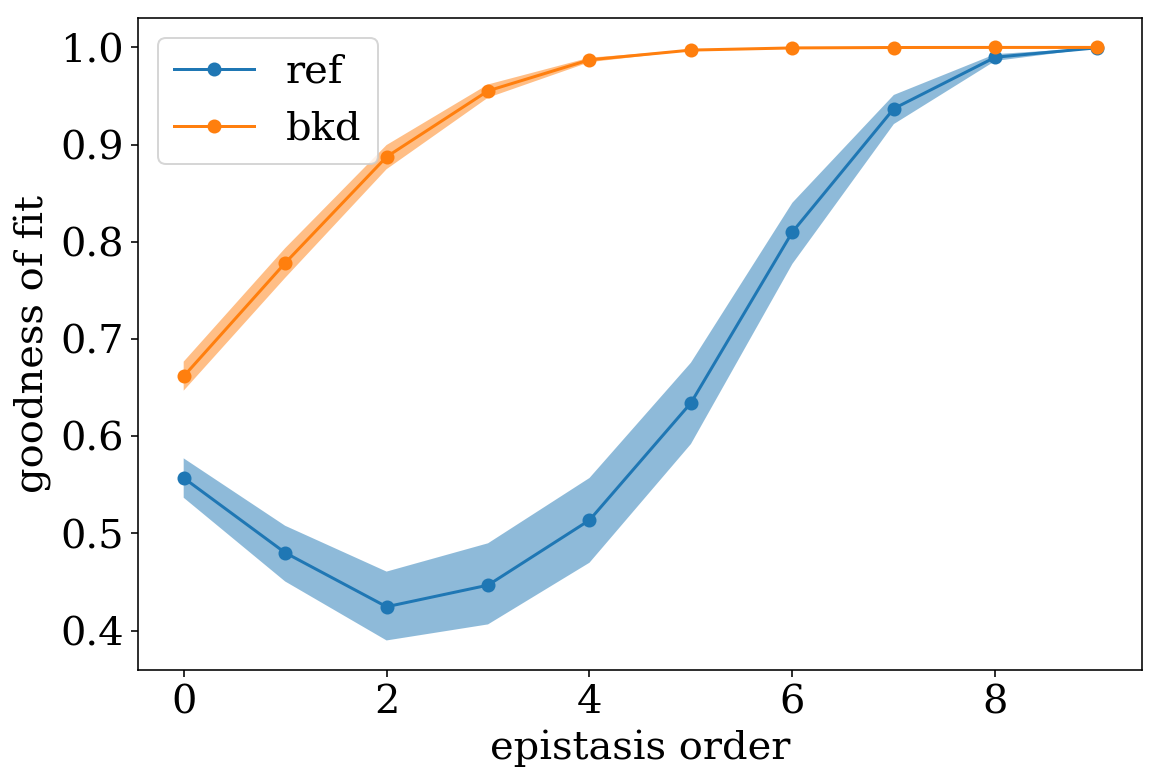

In [31]:
plt.plot(ref_boot[0],'-o',label='ref')
plt.fill_between(X,ref_boot[1],ref_boot[2],alpha=.5)
plt.plot(bkd_boot[0],'-o',label='bkd')
plt.fill_between(X,bkd_boot[1],bkd_boot[2],alpha=.5)
plt.legend()
plt.xlabel('epistasis order')
plt.ylabel('goodness of fit')
plt.show()

In [128]:
seq_len = 50
N = 1000
sequences = np.array(generate_random_sequences(seq_len,N))
simulator_1=RNA_landscape(sequences[0],norm_value=68.5) 

# seq

In [129]:
RNA.fold(sequences[0])

['......(((((.......(((((.(.(((....))).).))))).)))))', -11.600000381469727]

In [138]:
fitnesses = np.zeros(N)
for i in range(N):
    
    while fitnesses[i] == 0:
        fitnesses[i] = RNA.fold(sequences[i])[-1]
        sequences[i] = generate_random_sequences(seq_len,1)[0]

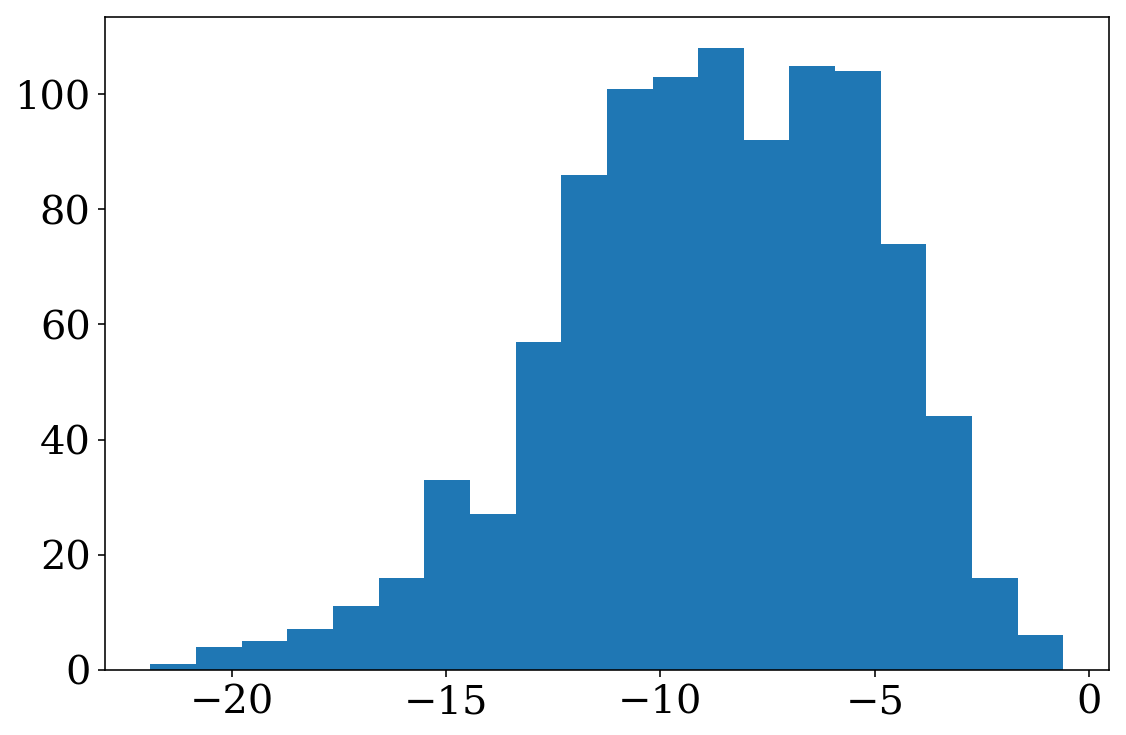

In [139]:
plt.hist(fitnesses,bins=20)
plt.show()

In [140]:
count_differences(*sequences[idx[3:4+1]])

TypeError: count_differences() takes 2 positional arguments but 1000 were given

In [141]:
diffs = np.zeros([N,N])
for i in range(N):
    for j in range(i,N):
        diffs[i,j] =count_differences(sequences[i],sequences[j])
        diffs[j,i] =diffs[i,j]

In [142]:
fit_dif = fitnesses[:,None]-fitnesses[None,:]
fit_dif[np.diag_indices_from(fit_dif)]=np.inf

/home/ianhi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


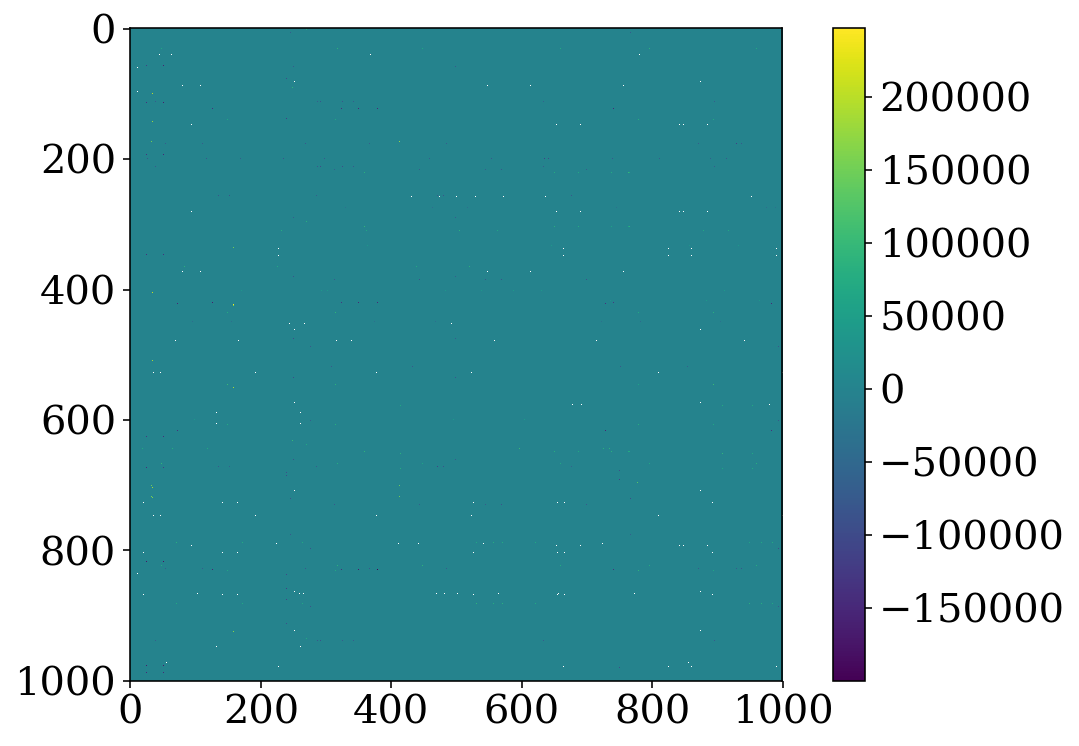

In [143]:
value_I_care_about = -1/(np.abs(diffs-10)*(fit_dif+10))
plt.imshow(value_I_care_about)
plt.colorbar()
plt.show()

In [144]:
fitness_dif_perc = (fitnesses[:,None]-fitnesses[None,:])/(fitnesses[:,None]+.001)

In [145]:
fitnesses[np.argsort(np.abs(fitnesses))]

array([ -0.60000002,  -0.80000001,  -1.        ,  -1.10000002,
        -1.39999998,  -1.5       ,  -1.70000005,  -1.89999998,
        -1.89999998,  -1.89999998,  -1.89999998,  -2.        ,
        -2.        ,  -2.0999999 ,  -2.29999995,  -2.4000001 ,
        -2.4000001 ,  -2.5       ,  -2.5       ,  -2.5999999 ,
        -2.70000005,  -2.70000005,  -2.79999995,  -2.79999995,
        -2.9000001 ,  -2.9000001 ,  -2.9000001 ,  -2.9000001 ,
        -3.0999999 ,  -3.0999999 ,  -3.0999999 ,  -3.0999999 ,
        -3.0999999 ,  -3.20000005,  -3.20000005,  -3.20000005,
        -3.20000005,  -3.20000005,  -3.20000005,  -3.20000005,
        -3.29999995,  -3.29999995,  -3.29999995,  -3.29999995,
        -3.29999995,  -3.4000001 ,  -3.4000001 ,  -3.4000001 ,
        -3.5       ,  -3.5       ,  -3.5       ,  -3.5       ,
        -3.5       ,  -3.5999999 ,  -3.5999999 ,  -3.5999999 ,
        -3.5999999 ,  -3.5999999 ,  -3.5999999 ,  -3.5999999 ,
        -3.5999999 ,  -3.70000005,  -3.70000005,  -3.70

In [146]:
idx = np.unravel_index(np.argmin(value_I_care_about),value_I_care_about.shape)

In [147]:
np.unravel_index(np.argsort(-value_I_care_about,None),value_I_care_about.shape)

(array([423, 405, 100, ..., 370, 384, 977]),
 array([158,  34,  34, ..., 430,  99, 859]))

In [148]:
value_I_care_about[idx[0],idx[1]]

-inf

In [149]:
print(fitnesses[idx[0]])
print(fitnesses[idx[1]])

-19.8999996185
-9.89999961853


In [150]:
diffs[idx[0],idx[1]]

45.0

In [151]:
arr = np.arange(1,5)
arr

array([1, 2, 3, 4])

In [152]:
(arr[:,None]-arr[None,:])/arr[:,None]

array([[ 0.        , -1.        , -2.        , -3.        ],
       [ 0.5       ,  0.        , -0.5       , -1.        ],
       [ 0.66666667,  0.33333333,  0.        , -0.33333333],
       [ 0.75      ,  0.5       ,  0.25      ,  0.        ]])

In [153]:
out = np.zeros([4,4])
for i in range(4):
    for j in range(4):
        out[i,j] = (arr[i]-arr[j])/arr[j]
out

array([[ 0.        , -0.5       , -0.66666667, -0.75      ],
       [ 1.        ,  0.        , -0.33333333, -0.5       ],
       [ 2.        ,  0.5       ,  0.        , -0.25      ],
       [ 3.        ,  1.        ,  0.33333333,  0.        ]])